
=== Balanced Random Forest ===
Confusion Matrix:
 [[1171  269]
 [  38  122]]
              precision    recall  f1-score   support

           0     0.9686    0.8132    0.8841      1440
           1     0.3120    0.7625    0.4428       160

    accuracy                         0.8081      1600
   macro avg     0.6403    0.7878    0.6635      1600
weighted avg     0.9029    0.8081    0.8400      1600

ROC-AUC: 0.8636501736111111


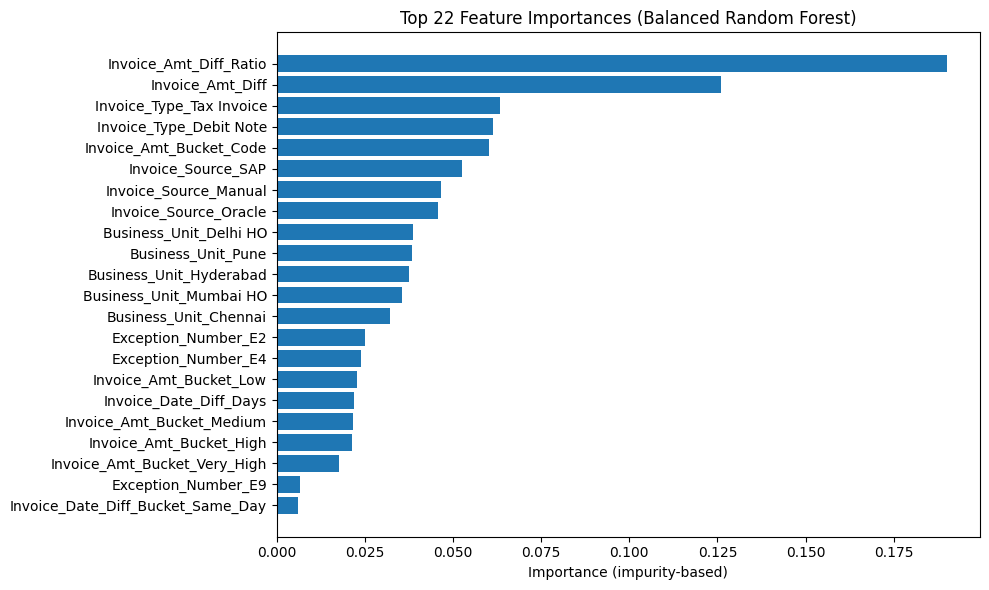


Saved feature importances:
- brf_feature_importances.csv


In [7]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.ensemble import BalancedRandomForestClassifier


# ==========================================================
# PATHS (single source of truth)
# ==========================================================
DATA_PATH = "D:/EY_Internship/p2p07_synthetic_10k_imbalance_with_pending.csv"

FEATURE_COLUMNS_PATH = "D:/EY_Internship/feature_columns.joblib"
INVOICE_BINS_PATH = "D:/EY_Internship/invoice_amt_bins.joblib"

BRF_MODEL_PATH = "brf_model.joblib"
    
PENDING_LOW_PATH = "pending_low_prob_brf.csv"
PENDING_HIGH_PATH = "pending_high_prob_brf.csv"

FEATURE_IMPORTANCE_PATH = "brf_feature_importances.csv"
# ==========================================================
# preprocess_p2p (unchanged)
# ==========================================================
def preprocess_p2p(
    df: pd.DataFrame,
    *,
    feature_columns: list[str] | None = None,
    invoice_amt_bins: np.ndarray | None = None,
    is_training: bool = False
):
    df = df.copy()

    df["Invoice_Amount"] = pd.to_numeric(df.get("Invoice_Amount"), errors="coerce")
    df = df.dropna(subset=["Invoice_Amount"])

    if is_training:
        _, bins = pd.qcut(df["Invoice_Amount"], q=5, retbins=True, duplicates="drop")
        invoice_amt_bins = bins

    if invoice_amt_bins is not None:
        labels = ["Very_Low", "Low", "Medium", "High", "Very_High"]
        effective_k = len(invoice_amt_bins) - 1
        effective_labels = labels[:effective_k]

        df["Invoice_Amt_Bucket"] = pd.cut(
            df["Invoice_Amount"],
            bins=invoice_amt_bins,
            labels=effective_labels,
            include_lowest=True
        )
        df["Invoice_Amt_Bucket_Code"] = df["Invoice_Amt_Bucket"].cat.codes.replace(-1, np.nan)
    else:
        df["Invoice_Amt_Bucket"] = pd.qcut(
            df["Invoice_Amount"], q=5,
            labels=["Very_Low", "Low", "Medium", "High", "Very_High"],
            duplicates="drop"
        )
        df["Invoice_Amt_Bucket_Code"] = pd.qcut(
            df["Invoice_Amount"], q=5, labels=False, duplicates="drop"
        )

    df = pd.get_dummies(df, columns=["Invoice_Amt_Bucket"], drop_first=True)

    df["Invoice_Date"] = pd.to_datetime(df.get("Invoice_Date"), errors="coerce", dayfirst=True)
    df["Posting_Date"] = pd.to_datetime(df.get("Posting_Date"), errors="coerce", dayfirst=True)

    dup_lookup = df[["Doc_id", "Invoice_Amount", "Invoice_Date"]].rename(
        columns={
            "Doc_id": "Duplicate_doc_id",
            "Invoice_Amount": "Dup_Invoice_Amount",
            "Invoice_Date": "Dup_Invoice_Date",
        }
    )
    df = df.merge(dup_lookup, on="Duplicate_doc_id", how="left")

    df["Invoice_Amt_Diff"] = (df["Invoice_Amount"] - df["Dup_Invoice_Amount"]).abs()
    df["Invoice_Date_Diff_Days"] = (df["Invoice_Date"] - df["Dup_Invoice_Date"]).dt.days.abs()
    df["Invoice_Amt_Diff_Ratio"] = df["Invoice_Amt_Diff"] / (df["Invoice_Amount"] + 1)

    def date_diff_bucket(x):
        if pd.isna(x):
            return np.nan
        if x == 0:
            return "Same_Day"
        elif x <= 2:
            return "1_2_Days"
        else:
            return "Above_2_Days"

    df["Invoice_Date_Diff_Bucket"] = df["Invoice_Date_Diff_Days"].apply(date_diff_bucket)

    DROP_COLS = [
        "Doc_id", "Invoice_ID", "Vendor_Code", "Vendor_Name",
        "Vendor_GSTIN", "Invoice_Number", "Currency", "comments",
        "Duplicate_doc_id", "Exception_Type",
        "Invoice_Amt_Bucket", "Invoice_Amount", "Dup_Invoice_Amount",
    ]
    df_model = df.drop(columns=DROP_COLS, errors="ignore")

    categorical_cols = [
        "Invoice_Type",
        "Invoice_Source",
        "Business_Unit",
        "Exception_Number",
        "Invoice_Date_Diff_Bucket",
    ]
    df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

    if is_training:
        feature_columns = df_model.columns.tolist()
    else:
        if feature_columns is None:
            raise ValueError("feature_columns is required for inference.")
        for c in feature_columns:
            if c not in df_model.columns:
                df_model[c] = 0
        extra = [c for c in df_model.columns if c not in feature_columns]
        if extra:
            df_model = df_model.drop(columns=extra)
        df_model = df_model[feature_columns]

    return df_model, feature_columns, invoice_amt_bins


# ==========================================================
# Load raw data + schema
# ==========================================================
df = pd.read_csv(DATA_PATH)
feature_columns = joblib.load(FEATURE_COLUMNS_PATH)

# ==========================================================
# Learn invoice bins from TRUE/FALSE only
# ==========================================================
df_tf = df[df["user_action_status"].isin(["TRUE", "FALSE"])].copy()
_, _, invoice_amt_bins = preprocess_p2p(df_tf, is_training=True)
joblib.dump(invoice_amt_bins, INVOICE_BINS_PATH)

# ==========================================================
# Preprocess full dataset aligned to schema
# ==========================================================
df_model, _, _ = preprocess_p2p(
    df,
    feature_columns=feature_columns,
    invoice_amt_bins=invoice_amt_bins,
    is_training=False
)

# ==========================================================
# Build training set
# ==========================================================
mask_tf = df["user_action_status"].isin(["TRUE", "FALSE"])
df_train = df_model.loc[mask_tf].copy()

df_train["y"] = df.loc[df_train.index, "user_action_status"].map({
    "FALSE": 0,
    "TRUE": 1
})

X = df_train[feature_columns]
y = df_train["y"].astype(int)

# ==========================================================
# Train / test split
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================================
# Balanced Random Forest
# ==========================================================
brf = BalancedRandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
brf.fit(X_train, y_train)

y_pred = brf.predict(X_test)
y_proba = brf.predict_proba(X_test)[:, 1]

print("\n=== Balanced Random Forest ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

joblib.dump(brf, BRF_MODEL_PATH)



# ==========================================================
# Feature importance (BRF)
# ==========================================================
imp = pd.DataFrame({
    "feature": feature_columns,
    "importance": brf.feature_importances_
}).sort_values("importance", ascending=False)

imp.to_csv(FEATURE_IMPORTANCE_PATH, index=False)

topk = 22
imp_plot = imp.head(topk)

plt.figure(figsize=(10, 6))
plt.barh(imp_plot["feature"][::-1], imp_plot["importance"][::-1])
plt.xlabel("Importance (impurity-based)")
plt.title(f"Top {topk} Feature Importances (Balanced Random Forest)")
plt.tight_layout()
plt.show()

print("\nSaved feature importances:")
print("-", FEATURE_IMPORTANCE_PATH)


In [9]:
import pandas as pd
import joblib

# ==========================================================
# PATHS
# ==========================================================
PENDING_INPUT_PATH = "D:/EY_Internship/pending_for_review_100_rows_clean.csv"
PENDING_OUTPUT_PATH = "pending_with_predictions_brf.csv"

BRF_MODEL_PATH = "brf_model.joblib"



# ==========================================================
# Load artifacts
# ==========================================================
brf_model = joblib.load(BRF_MODEL_PATH)
invoice_amt_bins = joblib.load(INVOICE_BINS_PATH)
feature_cols = joblib.load(FEATURE_COLUMNS_PATH)


# ==========================================================
# Load pending data
# ==========================================================
df_new = pd.read_csv(PENDING_INPUT_PATH)

# ==========================================================
# Preprocess (NO TRAINING, STRICT ALIGNMENT)
# ==========================================================
X_new, _, _ = preprocess_p2p(
    df_new,
    feature_columns=feature_cols,
    invoice_amt_bins=invoice_amt_bins,
    is_training=False
)

# ==========================================================
# Predict using BRF
# ==========================================================
proba = brf_model.predict_proba(X_new)[:, 1]

# Threshold can be tuned (example: 0.6)
pred = (proba >= 0.6).astype(int)

# ==========================================================
# Attach outputs
# ==========================================================
df_new["model_probability"] = proba
df_new["model_prediction"] = pred

# Optional: human-readable label
df_new["model_label"] = df_new["model_prediction"].map({
    0: "LOW_RISK",
    1: "HIGH_RISK"
})

# ==========================================================
# Save
# ==========================================================
df_new.to_csv(PENDING_OUTPUT_PATH, index=False)

print("Saved pending predictions →", PENDING_OUTPUT_PATH)


Saved pending predictions → pending_with_predictions_brf.csv
